In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
data_path = "/content/drive/MyDrive/nlp_proj_test/spa.txt"
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    pairs = [[s.strip() for s in line.split('\t')[:2]] for line in lines]
    return pairs

# Load sentence pairs
pairs = load_data(data_path)

In [ ]:
len(pairs)

141543

In [ ]:
pairs[:5]

[['Go.', 'Ve.'],
 ['Go.', 'Vete.'],
 ['Go.', 'Vaya.'],
 ['Go.', 'Váyase.'],
 ['Hi.', 'Hola.']]

In [ ]:
import tensorflow as tf

# Add start and end tokens to target sentences
def preprocess_data(pairs, num_samples=None):
    input_texts, target_texts = [], []
    for input_text, target_text in pairs[:num_samples]:
        # Add spaces around \t and \n to ensure they are treated as separate tokens
        target_text = " \t " + target_text.strip() + " \n "
        input_texts.append(input_text.strip())  # Strip whitespace
        target_texts.append(target_text)
    return input_texts, target_texts

input_texts, target_texts = preprocess_data(pairs,num_samples=80000)

# Tokenize
tokenizer_en = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token="<unk>")
tokenizer_en.fit_on_texts(input_texts)

tokenizer_es = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token="<unk>")
tokenizer_es.fit_on_texts(target_texts)

# Convert to sequences
input_sequences = tokenizer_en.texts_to_sequences(input_texts)
target_sequences = tokenizer_es.texts_to_sequences(target_texts)

# Padding
max_encoder_seq_length = max(len(seq) for seq in input_sequences)
max_decoder_seq_length = max(len(seq) for seq in target_sequences)

input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_encoder_seq_length, padding='post')
target_sequences = tf.keras.preprocessing.sequence.pad_sequences(target_sequences, maxlen=max_decoder_seq_length, padding='post')

# Vocabulary sizes
input_vocab_size = len(tokenizer_en.word_index) + 1
target_vocab_size = len(tokenizer_es.word_index) + 1

In [ ]:
print(target_texts[:5])  # Check the format of processed target sentences
print(len(tokenizer_en.word_index))  # Number of unique words in English
print(len(tokenizer_es.word_index))  # Number of unique words in Spanish
print(input_texts[0])  # Original sentence
print(input_sequences[0])  # Tokenized sentence
print(target_texts[0])  # Original target sentence
print(target_sequences[0],"\n--")  # Tokenized target sentence
print(input_sequences.shape)  # Should be (num_samples, max_encoder_seq_length)
print(target_sequences.shape)  # Should be (num_samples, max_decoder_seq_length)
print(input_sequences[0])  # Check padded version of the first sequence
print(target_sequences[0])  # Check padded version of the first target sequence
print(input_vocab_size)  # Vocabulary size for the input language
print(target_vocab_size)  # Vocabulary size for the target language

[' \t Ve. \n ', ' \t Vete. \n ', ' \t Vaya. \n ', ' \t Váyase. \n ', ' \t Hola. \n ']
15042
27876
Go.
[165   0   0   0   0   0   0   0   0]
 	 Ve. 
 
[   2 6143    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0] 
--
(80000, 9)
(80000, 17)
[165   0   0   0   0   0   0   0   0]
[   2 6143    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
15043
27877


In [ ]:
import gensim

# Load Word2Vec embeddings (Google News Word2Vec model)
word2vec_path = '/content/drive/MyDrive/nlp_proj_test/GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
embedding_dim = 300

In [ ]:
# print(word2vec['king'])  # Should return a 300-dimensional vector
print(len(word2vec['king']))  # Should return 300

300


In [ ]:
import numpy as np

def create_embedding_matrix(word_index, word2vec, embedding_dim):
    # embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    embedding_matrix = np.random.uniform(-0.1, 0.1, (len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in word2vec:
            embedding_matrix[i] = word2vec[word]
    return embedding_matrix

encoder_embedding_matrix = create_embedding_matrix(tokenizer_en.word_index, word2vec, embedding_dim)
decoder_embedding_matrix = create_embedding_matrix(tokenizer_es.word_index, word2vec, embedding_dim)

In [ ]:
print(encoder_embedding_matrix.shape)  # Should be (input_vocab_size, embedding_dim)
print(decoder_embedding_matrix.shape)  # Should be (target_vocab_size, embedding_dim)

(15043, 300)
(27877, 300)


In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_vocab_size, embedding_dim, weights=[encoder_embedding_matrix], trainable=False)(encoder_inputs)
encoder_bilstm = Bidirectional(LSTM(256, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_embedding)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(target_vocab_size, embedding_dim, weights=[decoder_embedding_matrix], trainable=False)(decoder_inputs)
decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention layer
attention = Attention()
context_vector = attention([decoder_outputs, encoder_outputs])

# Concatenate context vector and decoder outputs
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, context_vector])

# Dense output layer
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# Define model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 300)      │      4,512,900 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ [(None, None, 512),    │      1,140,736 │ embedding_2[0][0]      │
│ (Bidirectional)           │ (None, 256), (None,    │                │                        │
│                           │ 256), (None, 256),     │                │                        │
│                           │ (None, 256)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 300)      │      8,363,100 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 512)            │              0 │ bidirectional_1[0][1], │
│ (Concatenate)             │                        │                │ bidirectional_1[0][3]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 512)            │              0 │ bidirectional_1[0][2], │
│ (Concatenate)             │                        │                │ bidirectional_1[0][4]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 512),    │      1,665,024 │ embedding_3[0][0],     │
│                           │ (None, 512), (None,    │                │ concatenate_6[0][0],   │
│                           │ 512)]                  │                │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, None, 512)      │              0 │ lstm_3[0][0],          │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, None, 1024)     │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 27877)    │     28,573,925 │ concatenate_8[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 44,255,685 (168.82 MB)

 Trainable params: 31,379,685 (119.70 MB)

 Non-trainable params: 12,876,000 (49.12 MB)

In [ ]:
print(f"Encoder Outputs Shape: {encoder_outputs.shape}")
print(f"State_h Shape: {state_h.shape}")
print(f"State_c Shape: {state_c.shape}")
print(f"Decoder Outputs Shape: {decoder_outputs.shape}")
print(f"Context Vector Shape: {context_vector.shape}")
print(f"Decoder Combined Context Shape: {decoder_combined_context.shape}")
print(f"Final Decoder Outputs Shape: {decoder_outputs.shape}")

Encoder Outputs Shape: (None, None, 512)
State_h Shape: (None, 512)
State_c Shape: (None, 512)
Decoder Outputs Shape: (None, None, 27877)
Context Vector Shape: (None, None, 512)
Decoder Combined Context Shape: (None, None, 1024)
Final Decoder Outputs Shape: (None, None, 27877)


In [ ]:
# # Prepare decoder target data
decoder_input_data = target_sequences[:, :-1]
decoder_target_data = target_sequences[:, 1:]
decoder_target_data = np.expand_dims(decoder_target_data, -1)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
batch_size = 64
epochs = 50

history = model.fit(
    [input_sequences, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 89ms/step - accuracy: 0.7498 - loss: 2.1695 - val_accuracy: 0.7332 - val_loss: 1.8427
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 89s 89ms/step - accuracy: 0.8251 - loss: 1.0692 - val_accuracy: 0.7620 - val_loss: 1.5811
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 89s 89ms/step - accuracy: 0.8552 - loss: 0.7285 - val_accuracy: 0.7820 - val_loss: 1.4364
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 89s 89ms/step - accuracy: 0.8861 - loss: 0.4969 - val_accuracy: 0.7919 - val_loss: 1.3957
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 89s 89ms/step - accuracy: 0.9123 - loss: 0.3553 - val_accuracy: 0.7962 - val_loss: 1.3836
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 89s 89ms/step - accuracy: 0.9301 - loss: 0.2718 - val_accuracy: 0.8006 - val_loss: 1.3781
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 89s 89ms/step - accuracy: 0.9416 - loss: 0.2203 - val_accuracy: 0.8013 - val_loss: 1.4068
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 89s 89ms/step - accuracy: 0.9510 -

Text(0, 0.5, 'Loss')

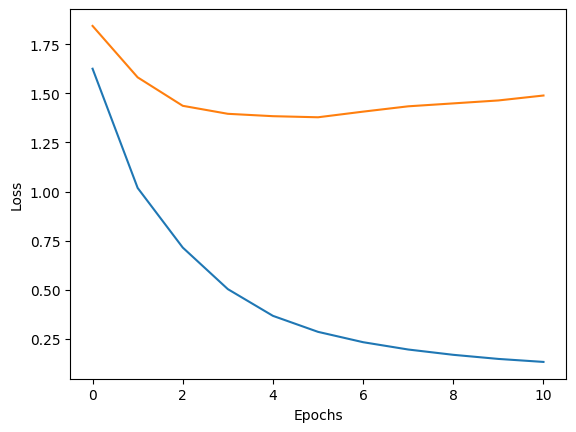

In [ ]:
# plot the loss curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
# Encoder inference model
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Decoder inference model
decoder_state_input_h = Input(shape=(512,))
decoder_state_input_c = Input(shape=(512,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=decoder_states_inputs
)
context_vector = attention([decoder_lstm_outputs, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1)([decoder_lstm_outputs, context_vector])
decoder_outputs = decoder_dense(decoder_combined_context)

decoder_model = Model(
    [decoder_inputs, encoder_outputs] + decoder_states_inputs,
    [decoder_outputs, state_h, state_c]
)

In [ ]:
def decode_sequence(input_seq):
    # Get the encoder output and states
    encoder_output, state_h, state_c = encoder_model.predict(input_seq)

    # Placeholder: Use the most frequent word as the start token
    placeholder_start_token = list(tokenizer_es.word_index.values())[0]  # First valid token index
    print(f"Using placeholder start token index: {placeholder_start_token}")

    # Prepare the target sequence with the placeholder start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = placeholder_start_token

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Predict next token
        output_tokens, h, c = decoder_model.predict([target_seq, encoder_output, state_h, state_c])

        # Sample the token with the highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer_es.index_word.get(sampled_token_index, '')

        # Stop at end token or max sequence length
        if sampled_word == '\n' or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
        else:
            decoded_sentence += sampled_word + ' '

        # Update target sequence and states
        target_seq[0, 0] = sampled_token_index
        state_h, state_c = h, c

    return decoded_sentence

In [ ]:
# Define encoder inference model
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])
# Decoder inference model
decoder_inputs_single = Input(shape=(1,), name="decoder_inputs_single")

# Reuse the embedding layer
decoder_embedding_layer = Embedding(
    input_dim=target_vocab_size,
    output_dim=embedding_dim,
    weights=[decoder_embedding_matrix],
    trainable=False,
    name="decoder_embedding_layer"
)

decoder_embedding_single = decoder_embedding_layer(decoder_inputs_single)

decoder_state_input_h = Input(shape=(512,), name="decoder_state_input_h")
decoder_state_input_c = Input(shape=(512,), name="decoder_state_input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding_single, initial_state=decoder_states_inputs
)

context_vector = attention([decoder_lstm_outputs, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1)([decoder_lstm_outputs, context_vector])
decoder_outputs = decoder_dense(decoder_combined_context)

decoder_model = Model(
    [decoder_inputs_single, encoder_outputs] + decoder_states_inputs,
    [decoder_outputs, state_h, state_c]
)

# Decode sequence
def decode_sequence(input_seq):
    encoder_output, state_h, state_c = encoder_model.predict(input_seq)

    start_token = tokenizer_es.word_index.get('\t', 0)
    print(f"Using start token index: {start_token}")

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, encoder_output, state_h, state_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer_es.index_word.get(sampled_token_index, '<unk>')

        if sampled_word == '\n' or len(decoded_sentence.split()) > max_decoder_seq_length:
            stop_condition = True
        else:
            decoded_sentence += sampled_word + ' '

        target_seq[0, 0] = sampled_token_index
        state_h, state_c = h, c

    return decoded_sentence.strip()

In [ ]:
# Tokenize and pad the test data
test_input_sequences = tokenizer_en.texts_to_sequences(input_texts[70000:])
test_input_sequences = pad_sequences(test_input_sequences, maxlen=max_encoder_seq_length, padding='post')

test_target_sequences = tokenizer_es.texts_to_sequences(target_texts[70000:])
test_target_sequences = pad_sequences(test_target_sequences, maxlen=max_decoder_seq_length, padding='post')

In [ ]:
# Prepare decoder input and target sequences for testing
test_decoder_input_data = test_target_sequences[:, :-1]  # Remove last token for decoder input
test_decoder_target_data = test_target_sequences[:, 1:]  # Remove first token for decoder target
test_decoder_target_data = np.expand_dims(test_decoder_target_data, -1)  # Expand dims for sparse_categorical_crossentropy

# Evaluate the model
test_loss, test_accuracy = model.evaluate(
    [test_input_sequences, test_decoder_input_data],
    test_decoder_target_data,
    batch_size=64
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8020 - loss: 1.3413
Test Loss: 1.4268548488616943
Test Accuracy: 0.793874979019165


In [ ]:
for i in range(5):  # Test on first 5 samples
    test_input_seq = test_input_sequences[i:i+1]
    predicted_sentence = decode_sequence(test_input_seq)
    print(f"Input Sentence: {input_texts[70000 + i]}")
    print(f"Predicted Translation: {predicted_sentence}")
    print(f"Actual Translation: {target_texts[70000 + i]}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Using start token index: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Input Sentence: I need a taxi to the airport.
Predicted Translation: necesito un lugar para la luna.
Actual Translation:  	 Necesito un taxi que vaya al aeropuerto. 
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Using start token index: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input Sentence: I need something for a child.
Predicted Translation: necesito un niño.
Actual Translation:  	 Necesito algo para un niño. 
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Using start token index: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste

In [ ]:
def preprocess_data(pairs, num_samples=None):
    input_texts, target_texts = [], []
    for input_text, target_text in pairs[80000:num_samples]:
        # Add spaces around \t and \n to ensure they are treated as separate tokens
        target_text = " \t " + target_text.strip() + " \n "
        input_texts.append(input_text.strip())  # Strip whitespace
        target_texts.append(target_text)
    return input_texts, target_texts

test_input_texts, test_target_texts = preprocess_data(pairs,num_samples=90000)

test_input_sequences = tokenizer_en.texts_to_sequences(test_input_texts[:])
test_input_sequences = pad_sequences(test_input_sequences, maxlen=max_encoder_seq_length, padding='post')

test_target_sequences = tokenizer_es.texts_to_sequences(test_target_texts[:])
test_target_sequences = pad_sequences(test_target_sequences, maxlen=max_decoder_seq_length, padding='post')

test_loss, test_accuracy = model.evaluate(
    [test_input_sequences, test_decoder_input_data],
    test_decoder_target_data,
    batch_size=64
)

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6512 - loss: 3.7349
